# Datenauswertung der Windkraftanlage Egneos Wind1


Webseite: http://egneos.de/portfoli/projekt-neos-wind-1/

Lage: http://www.openstreetmap.org/node/3996237479#map=15/51.3463/13.3807

Typ: Enercon E-101 http://www.enercon.de/produkte/ep-3/e-101/
* 135m Mast
* 101m Rotordurchmesser
* 3.05 MW
* Bauart: getriebelos, variable Drehzahl, Einzelblattverstellung
* Baujahr 2015


## Motivation für Datenauswertung:

>Man besitzt nur das, was man aufschrauben und wo man reinschauen kann.

* Mehr als nur Freude an einer ggf. kommenden Rendite
* Begeisterung an faszinierender Technik (3MW sind beeindruckend. Kein Sportwagen mit solch einer Leistung.)
* Die Anlage ist eine nette "kleine" Wetterstation
* (Anlagenmonitoring) . Das macht aktiv der Hersteller.
* Interesse an Datenanalyse (insbesonders der physikalischen Zusammenhänge.) 
* Interesse an Industriesteuerungen
* Analyse des detailierten Zeitverlaufs
* Die Energiewende verstehen und unterstützen
* Hoffnung ggf. Begeisterung bei anderen zu wecken

## Vorgehensweise
* über VPN Zugriff auf die Anlage
* Kommunikation mit dem Scada-System über OPC XML-DA mittels PyOPC 
* Genutzt wird Python, Ipython-Notebook, Pandas
* Alles in eine Datenbank (SQLite) schreiben
* Datenvisualisierung über Matplotlib

### Gespeichert werden:
* Anlagedaten
 * Windgeschwindigkeit und Windrichtung
 * Rotordrehzahl und Pitchwinkel
 * Leistung
 * Stromzähler
 * Betriebstunden
 * Blindstrom
 
* Temperaturdaten
 * 25 Sensoren in der Gondel 
 * 14 Sensoren in den Elektroschränken unten im Mast
* Verfügbarkeitsdaten 

Historische Daten werden aggregiert als Min, Max und Mittelwert gespeichert.

### Neben der Angabe von Live-Daten, speichert die Anlage Daten für eine jeweils bestimmte Zeit:
* RAW-Daten minütlich für die letzten 12 Stunden
* REP-Daten aller 10 Minuten für die letzten 2 Tage
* DAY-Daten täglich 
* Week-Daten wöchentlich 
* Month-Daten monatlich
* Year-Daten jährlich
 

## zukünftige Ziele
* Automatisierung
* Integration der Egneos Solaranlage
* Bereitstellung des Dienstes an andere Energiegenossenschaften und Energiewendler
* Nutzung spezieller Datenstandards (MQTT, OpenEnergyMonitor (https://emoncms.org/), Sensor Observation Service,  Sensornetzwerke http://codeforchemnitz.de/projects/sensor/)
* interaktive Diagramme
* Integrationsmöglichkeiten von Verbrauchsdaten
* Excel-Unterstützung (wenn gewünscht)
* Live-Daten auf Telefon und Smart-Watches ...

In [152]:
#!/usr/bin/env python
%matplotlib inline

#from PyOPC.OPCContainers import *
#from PyOPC.XDAClient import XDAClient

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sqlalchemy import create_engine # database connection
import datetime as dt
from IPython.display import display
from IPython.display import clear_output

import scipy.stats

#http://pyopc.sourceforge.net/
#https://plot.ly/python/big-data-analytics-with-pandas-and-sqlite/

In [4]:
disk_engine = create_engine('sqlite:///egneos2.db')

## Daten der letzten 12 Stunden

In [170]:
df = pd.read_sql_query('SELECT *'
                       ' FROM Wecstd_Raw limit 720 offset (select count(*) FROM Wecstd_Raw)-720'
                       , disk_engine)
df.index=pd.DatetimeIndex(df["index"])
df.drop('index', axis=1, inplace=True)
pd.read_sql_query('SELECT Count(*) '
                       'FROM Wecstd_Raw '
                       , disk_engine)

,Count(*)
0,77827


In [171]:
df.head()

,Source,Values,MitVwind,MaxVwind,MinVwind,MitNRotor,MaxNRotor,MinNRotor,MitP,MaxP,...,PavaExtern,Pitch,?1,?2,?3,?4,?5,?6,?7,?8
2016-04-16 22:15:00,Raw,1,8.2,9.3,7.4,12.14,12.72,11.64,1402,1628,...,1417,1,65.535003,65.535003,65.535003,6553.500098,6553.500098,6553.500098,0,65535
2016-04-16 22:16:00,Raw,1,7.9,8.9,6.7,12.32,12.73,11.86,1481,1635,...,1498,1,65.535003,65.535003,65.535003,6553.500098,6553.500098,6553.500098,0,65535
2016-04-16 22:17:00,Raw,1,8.2,8.8,7.6,12.25,12.54,11.90,1438,1546,...,1418,1,65.535003,65.535003,65.535003,6553.500098,6553.500098,6553.500098,0,65535
2016-04-16 22:18:00,Raw,1,7.9,8.6,7.1,12.18,12.42,11.91,1416,1501,...,1402,1,65.535003,65.535003,65.535003,6553.500098,6553.500098,6553.500098,0,65535
2016-04-16 22:19:00,Raw,1,8.2,8.9,7.3,12.31,12.50,12.05,1468,1537,...,1453,1,65.535003,65.535003,65.535003,6553.500098,6553.500098,6553.500098,0,65535


In [172]:
df.columns

Index([u'Source', u'Values', u'MitVwind', u'MaxVwind', u'MinVwind',
       u'MitNRotor', u'MaxNRotor', u'MinNRotor', u'MitP', u'MaxP', u'MinP',
       u'GoPos', u'Hour', u'Wexp', u'Minutes', u'MitQ', u'MaxQ', u'MinQ',
       u'PavaVwind', u'PavaTech', u'PavaForceM', u'PavaExtern', u'Pitch',
       u'?1', u'?2', u'?3', u'?4', u'?5', u'?6', u'?7', u'?8'],
      dtype='object')

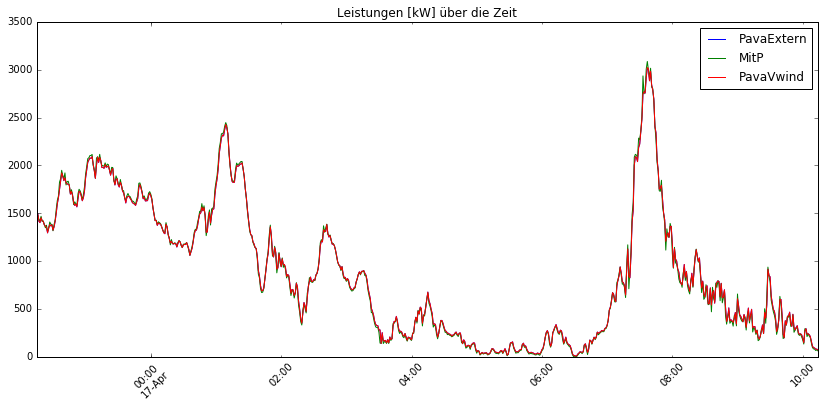

In [173]:
df[[u'PavaExtern','MitP','PavaVwind']].plot(rot=45,ylim=(0,3500),figsize=(14,6))
plt.title(u'Leistungen [kW] über die Zeit');

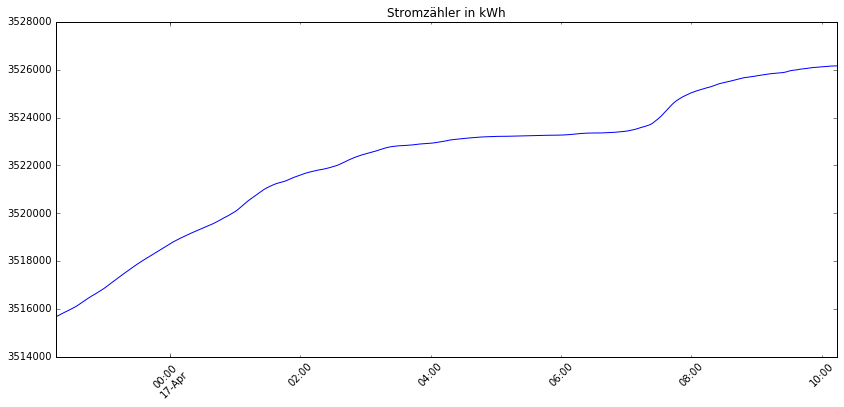

In [174]:
df['Wexp'].plot(rot=45,figsize=(14,6));
plt.title(u'Stromzähler in kWh');

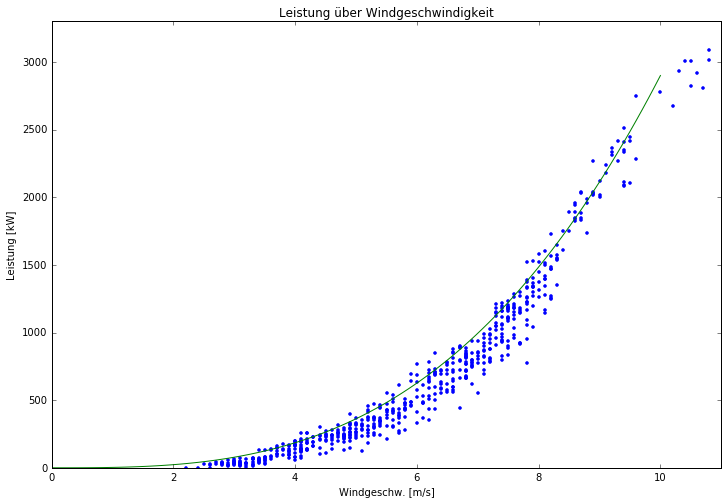

In [149]:
fig=plt.figure(figsize=(12,8))
plt.plot(df[u'MitVwind'],df[[u'MitP']],'.')
x1,x2,y1,y2 = plt.axis()
v=np.linspace(0,10,100)
power=2.9*v**3
plt.plot(v,power)
plt.axis((0,x2,0,3300));
plt.xlabel("Windgeschw. [m/s]")
plt.ylabel("Leistung [kW]");
plt.title(u'Leistung über Windgeschwindigkeit');

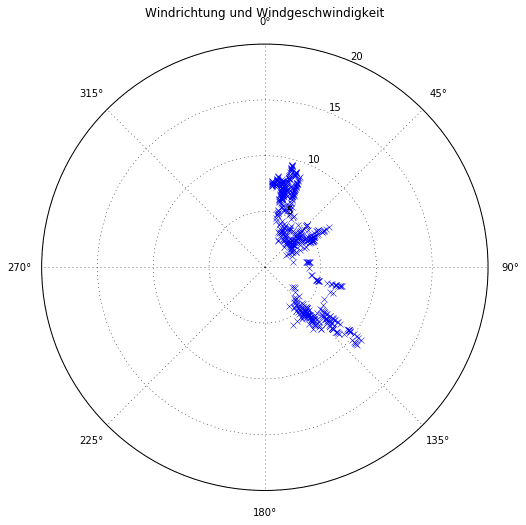

In [157]:
fig=plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')
ax.set_theta_direction(-1)
ax.plot(np.pi+df[[u'GoPos']].values*np.pi/180,df[[u'MitVwind']].values,'x')
ax.set_theta_zero_location("N")
ax.set_rmax(20)
ax.grid(True)
plt.title('Windrichtung und Windgeschwindigkeit');

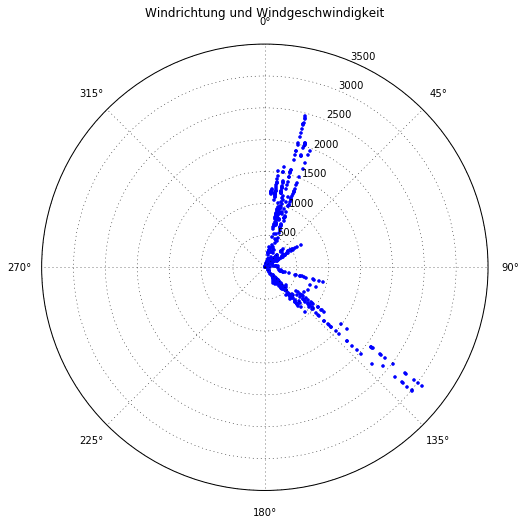

In [151]:
fig=plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')
ax.set_theta_direction(-1)
ax.plot(np.pi+df[[u'GoPos']].values*np.pi/180,df[[u'MitP']].values,'.')
ax.set_theta_zero_location("N")
ax.set_rmax(3500)
ax.grid(True)
plt.title('Windrichtung und Windgeschwindigkeit');

## Langzeitdaten

In [177]:
#Alle Daten
df = pd.read_sql_query('SELECT *'
                       ' FROM Wecstd_Raw '
                       , disk_engine)
df.index=pd.DatetimeIndex(df["index"])
df.drop('index', axis=1, inplace=True)
pd.read_sql_query('SELECT Count(*) '
                       'FROM Wecstd_Raw '
                       , disk_engine)

,Count(*)
0,77827


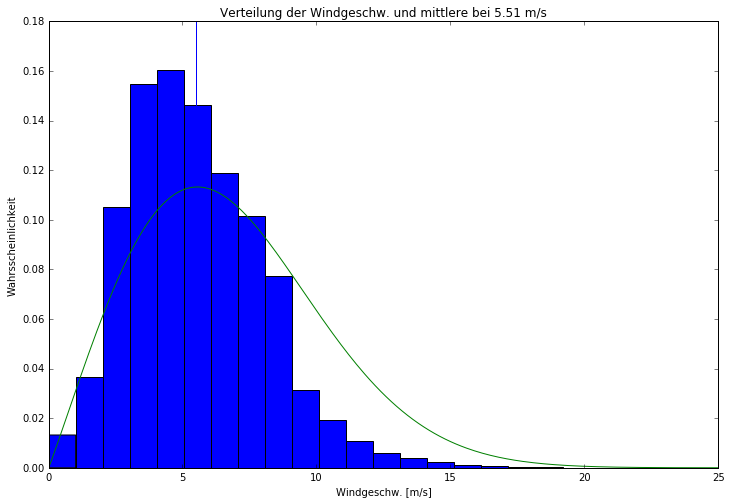

In [138]:
fig=plt.figure(figsize=(12,8))
plt.hist(df[[u'MitVwind']].values,normed=True,bins=20);
x1,x2,y1,y2 = plt.axis()
plt.axis((0,x2,0,y2));
mean=df[[u'MitVwind']].mean().values[0]
plt.axvline(mean);
rv = scipy.stats.exponweib(1.0, 2.05, scale=7.7)  #Prognose mit mittel. vWind 7.7m/s, k=2.05 und x=1 ?
x_range = np.arange(0, 30, 0.1)
plt.plot(x_range, rv.pdf(x_range));
plt.title('Verteilung der Windgeschw. und mittlere bei ' +"%.2f"% mean +" m/s")
plt.xlabel("Windgeschw. [m/s]")
plt.ylabel("Wahrsscheinlichkeit"); #ToDo Weibull-Verteilung;

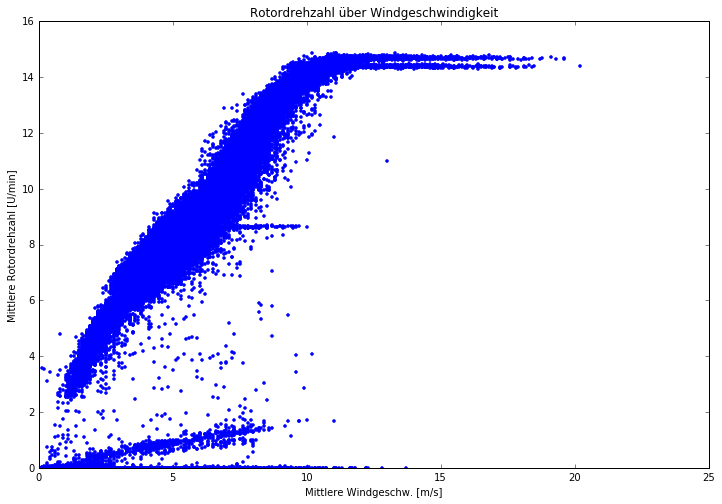

In [179]:
fig=plt.figure(figsize=(12,8))
plt.plot(df[u'MitVwind'].values  ,df[[u'MitNRotor']].values,'.')
plt.xlabel(u'Mittlere Windgeschw. [m/s]')
plt.ylabel(u'Mittlere Rotordrehzahl [U/min]')
x1,x2,y1,y2 = plt.axis()
plt.axis((0,x2,0,y2));
plt.title(u'Rotordrehzahl über Windgeschwindigkeit');

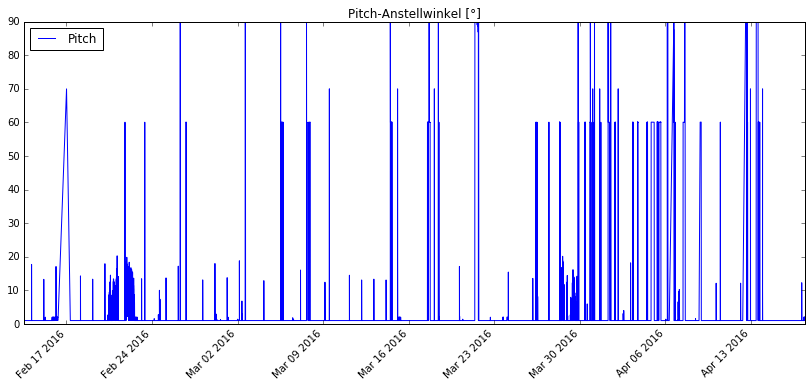

In [140]:
df[[u'Pitch']].plot(rot=45,ylim=(0,90),figsize=(14,6));
plt.title(u'Pitch-Anstellwinkel [°]');

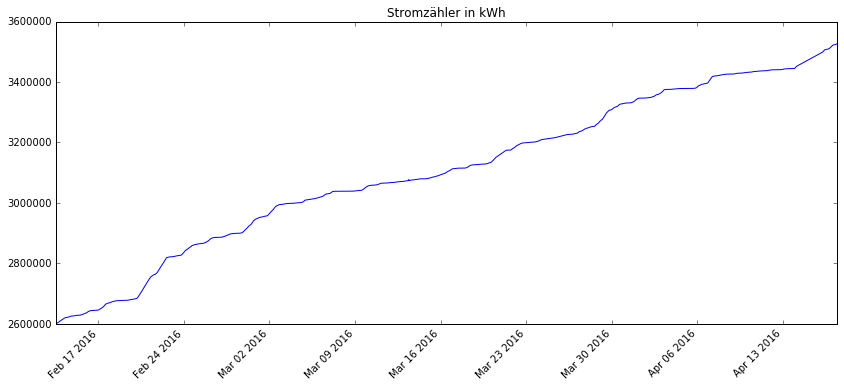

In [178]:
df['Wexp'].plot(rot=45,figsize=(14,6));
plt.title(u'Stromzähler in kWh');

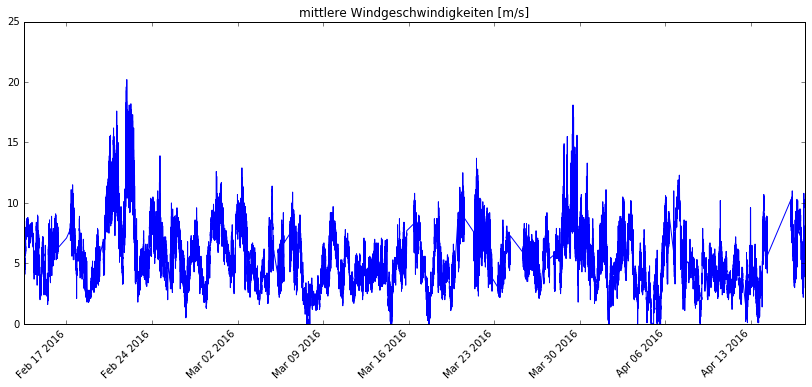

In [180]:
df.MitVwind.plot(rot=45,ylim=(0,25),figsize=(14,6));
plt.title(u'mittlere Windgeschwindigkeiten [m/s]');

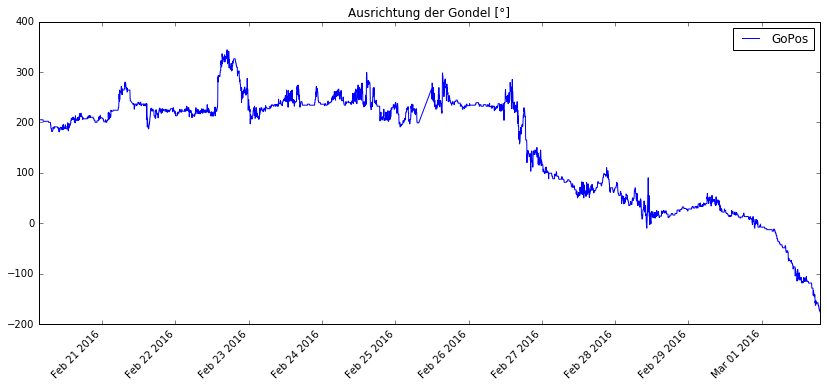

In [261]:
df[['GoPos']].plot(rot=45,figsize=(14,6));
plt.title(u'Ausrichtung der Gondel [°]');

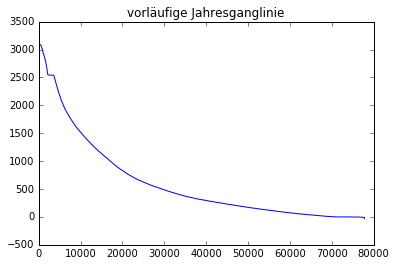

In [154]:
plt.plot(-np.sort(-df['MitP'].values))
plt.title(u'vorläufige Jahresganglinie');

## Temperaturen

In [181]:
df_temp = pd.read_sql_query('SELECT *'
                       ' FROM T101a1_Rep limit 15000 offset (select count(*) FROM T101a1_Rep)-15000'
                       , disk_engine)

df_temp.index=pd.DatetimeIndex(df_temp["index"])
df_temp.drop('index', axis=1, inplace=True)
df_temp.shape

(7394, 27)

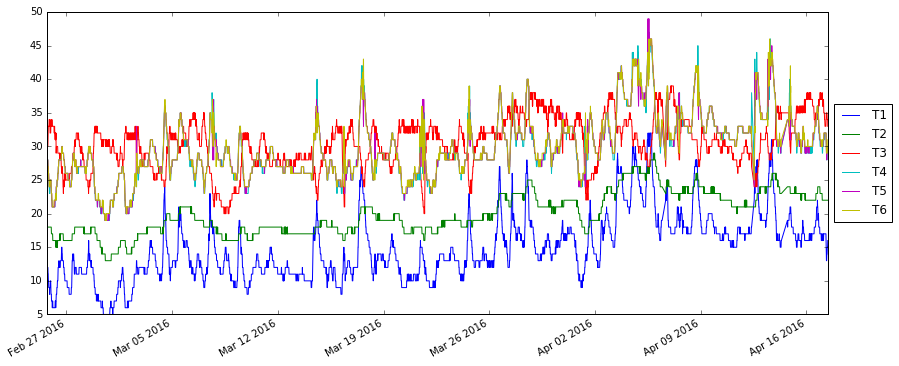

In [182]:
df_temp.ix[:,2:8].plot(figsize=(14,6)).legend(loc='center left', bbox_to_anchor=(1, 0.5));

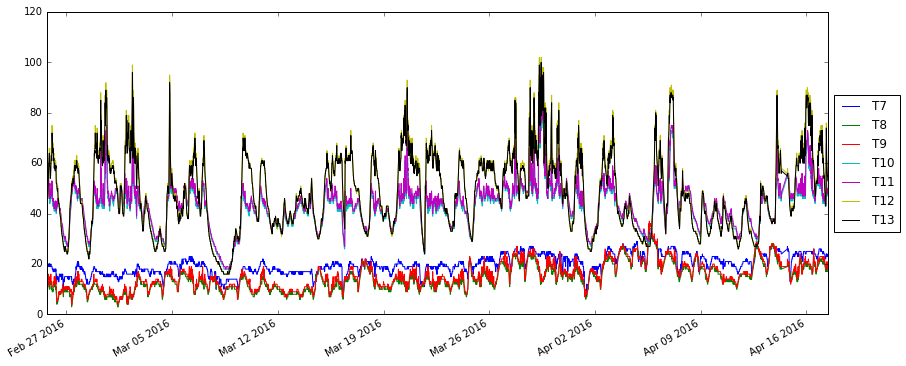

In [183]:
df_temp.ix[:,8:15].plot(figsize=(14,6)).legend(loc='center left', bbox_to_anchor=(1, 0.5));

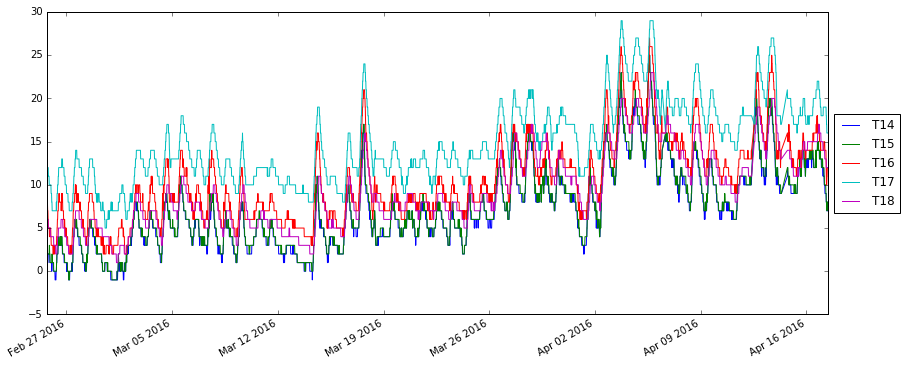

In [184]:
df_temp.ix[:,15:20].plot(figsize=(14,6)).legend(loc='center left', bbox_to_anchor=(1, 0.5));

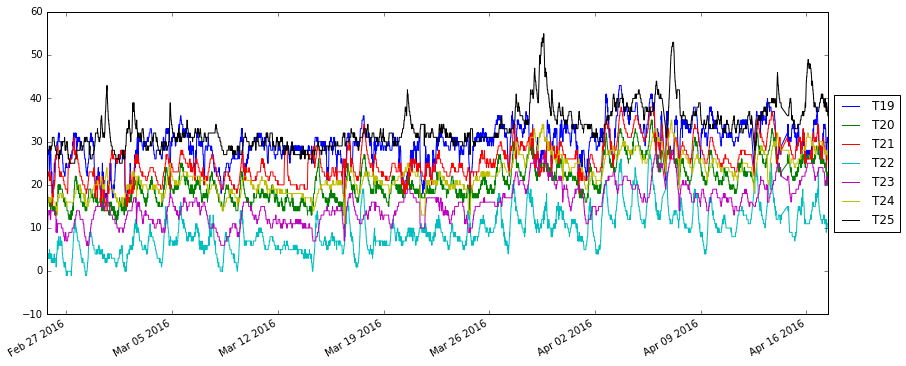

In [185]:
df_temp.ix[:,20:].plot(figsize=(14,6)).legend(loc='center left', bbox_to_anchor=(1, 0.5));

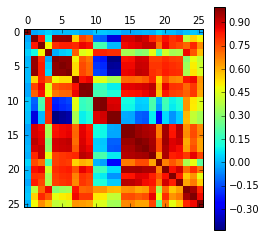

In [186]:
#Correlationsmatrix der Temperaturen
fig=plt.figure(figsize=(12,12));
plt.matshow(df_temp.corr());
plt.colorbar();

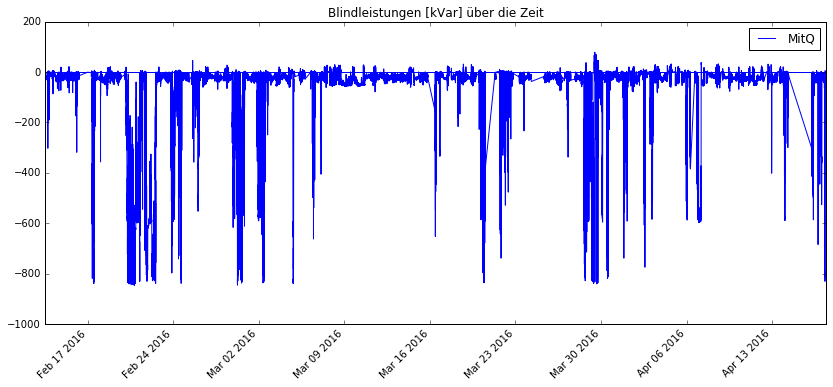

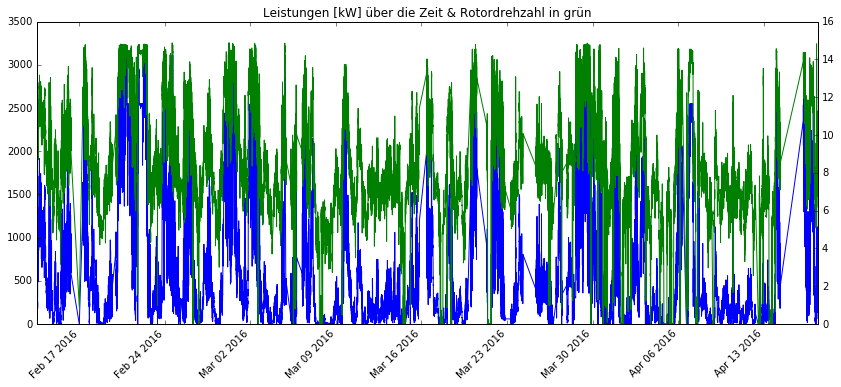

In [187]:
df[['MitQ']].plot(rot=45,figsize=(14,6))
plt.title(u'Blindleistungen [kVar] über die Zeit');
plt.axhline(0)
plt.show()
df['MitP'].plot(rot=45,ylim=(0,3500),figsize=(14,6))
df[u'MitNRotor'].plot(secondary_y=True,rot=45,figsize=(14,6))
plt.title(u'Leistungen [kW] über die Zeit & Rotordrehzahl in grün');